### Task 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import he_uniform
from keras.regularizers import l2
import matplotlib.pyplot as plt
from google.colab import files



In [ ]:
folder_path = '/content/drive/MyDrive/AML_Project/cifar'
os.chdir(folder_path)

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_batches(filenames):
    data, labels = [], []
    for filename in filenames:
        batch = unpickle(filename)  # Assuming this correctly unpickles the data
        data.append(batch[b'data'])
        labels.append(batch[b'labels'])
    data = np.concatenate(data)
    labels = np.concatenate(labels)

    # Reshape the data to the format (num_samples, height, width, channels)
    num_images = data.shape[0]
    data = data.reshape(num_images, 3, 32, 32).transpose(0, 2, 3, 1)
    return data, labels

In [ ]:
#load
train_filenames = [f'data_batch_{i}' for i in range(1, 6)]
test_filename = 'test_batch'
train_data, train_labels = load_batches(train_filenames)
test_data, test_labels = load_batches([test_filename])

In [ ]:
#reshape and normalize
train_data = train_data / 255.0
test_data = test_data / 255.0

#one-hot encode labels
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

In [ ]:
def create_nullmodel():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

nullmodel = create_nullmodel()

In [ ]:
nullmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense (Dense)               (None, 64)                460864    
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 462410 (1.76 MB)
Trainable params: 462410 (1.76 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

### Task 2 - Experiments
a) data augmentation  
b) size of training batch  
c) batch normalisation  
d)force overfit and solve it using any method to control the complexity of the model

In [ ]:
# DATA AUGMENTATION
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Create a single augmented dataset
augmented_data, augmented_label = next(data_generator.flow(train_data, train_labels, batch_size=len(train_data)))

# Train null model with original data
null_history = nullmodel.fit(train_data, train_labels, epochs=10, validation_split=0.2)

# Train a new model with augmented data
augmented_model = create_nullmodel()
augmented_history = augmented_model.fit(augmented_data, augmented_label, epochs=10, validation_split=0.2)

# Plot accuracy and loss for both models
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(null_history.history['accuracy'], label='Null Model - Training Accuracy')
plt.plot(null_history.history['val_accuracy'], label='Null Model - Validation Accuracy')
plt.plot(augmented_history.history['accuracy'], label='Augmented Model - Training Accuracy')
plt.plot(augmented_history.history['val_accuracy'], label='Augmented Model - Validation Accuracy')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right', fontsize=6)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(null_history.history['loss'], label='Null Model - Training Loss')
plt.plot(null_history.history['val_loss'], label='Null Model - Validation Loss')
plt.plot(augmented_history.history['loss'], label='Augmented Model - Training Loss')
plt.plot(augmented_history.history['val_loss'], label='Augmented Model - Validation Loss')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right', fontsize=6)

plt.savefig('dataaugmentation.jpeg')

plt.show()


Epoch 1/10
3125/3125 [==============================] - 46s 14ms/step - loss: 1.9882 - accuracy: 0.2576 - val_loss: 1.8935 - val_accuracy: 0.3078
Epoch 2/10
3125/3125 [==============================] - 45s 14ms/step - loss: 1.9015 - accuracy: 0.2935 - val_loss: 1.9793 - val_accuracy: 0.2839
Epoch 3/10
3125/3125 [==============================] - 44s 14ms/step - loss: 1.8690 - accuracy: 0.3035 - val_loss: 1.8625 - val_accuracy: 0.3078
Epoch 4/10
3125/3125 [==============================] - 43s 14ms/step - loss: 1.8494 - accuracy: 0.3133 - val_loss: 1.9224 - val_accuracy: 0.3003
Epoch 5/10
3125/3125 [==============================] - 44s 14ms/step - loss: 1.8354 - accuracy: 0.3182 - val_loss: 1.8309 - val_accuracy: 0.3263
Epoch 6/10
3125/3125 [==============================] - 45s 14ms/step - loss: 1.8273 - accuracy: 0.3184 - val_loss: 1.8772 - val_accuracy: 0.3060
Epoch 7/10
3125/3125 [==============================] - 45s 14ms/step - loss: 1.8170 - accuracy: 0.3276 - val_loss: 1.9263 -

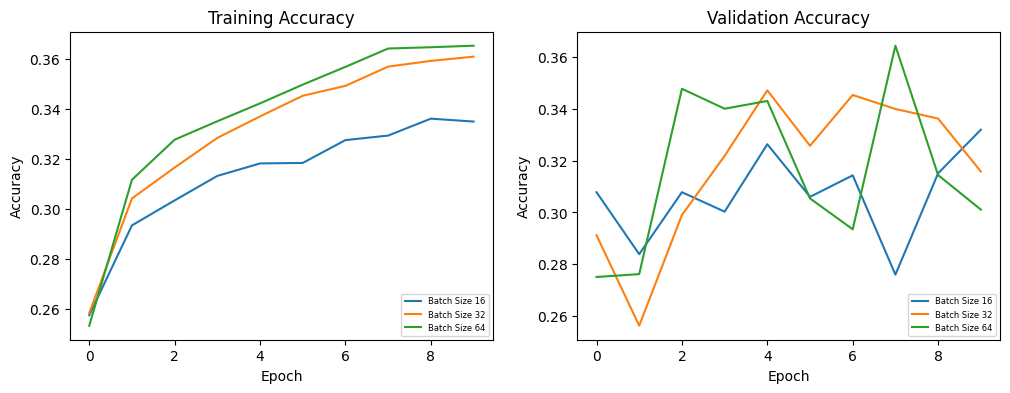

In [ ]:
# SIZE OF TRAINING BATCH
train_accuracy_list = []
val_accuracy_list = []
train_loss_list = []
val_loss_list = []

# try different batch sizes
batch_sizes = [16, 32, 64]

for batch_size in batch_sizes:
    # Create a new instance of the model for each batch size
    model_instance = create_nullmodel()

    # Train the model using the data generator with the specified batch size
    history = model_instance.fit(data_generator.flow(train_data, train_labels, batch_size=batch_size),
                                epochs=10,
                                validation_data=(test_data, test_labels))

    # Record metrics
    train_accuracy_list.append(history.history['accuracy'])
    val_accuracy_list.append(history.history['val_accuracy'])
    train_loss_list.append(history.history['loss'])
    val_loss_list.append(history.history['val_loss'])

# Plot metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i, batch_size in enumerate(batch_sizes):
    plt.plot(train_accuracy_list[i], label=f'Batch Size {batch_size}')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right', fontsize=6)

plt.subplot(1, 2, 2)
for i, batch_size in enumerate(batch_sizes):
    plt.plot(val_accuracy_list[i], label=f'Batch Size {batch_size}')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right', fontsize=6)

plt.savefig('batchsize.jpeg')

plt.show()

Epoch 1/10
1563/1563 [==============================] - 15s 6ms/step - loss: 1.4021 - accuracy: 0.5110 - val_loss: 1.6168 - val_accuracy: 0.4701
Epoch 2/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.1184 - accuracy: 0.6094 - val_loss: 1.2416 - val_accuracy: 0.5683
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9936 - accuracy: 0.6531 - val_loss: 1.2056 - val_accuracy: 0.5835
Epoch 4/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.8936 - accuracy: 0.6865 - val_loss: 1.7230 - val_accuracy: 0.4850
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8067 - accuracy: 0.7194 - val_loss: 1.2168 - val_accuracy: 0.6045
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7130 - accuracy: 0.7529 - val_loss: 1.2093 - val_accuracy: 0.5968
Epoch 7/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.6329 - accuracy: 0.7787 - val_loss: 1.2398 - val_accur

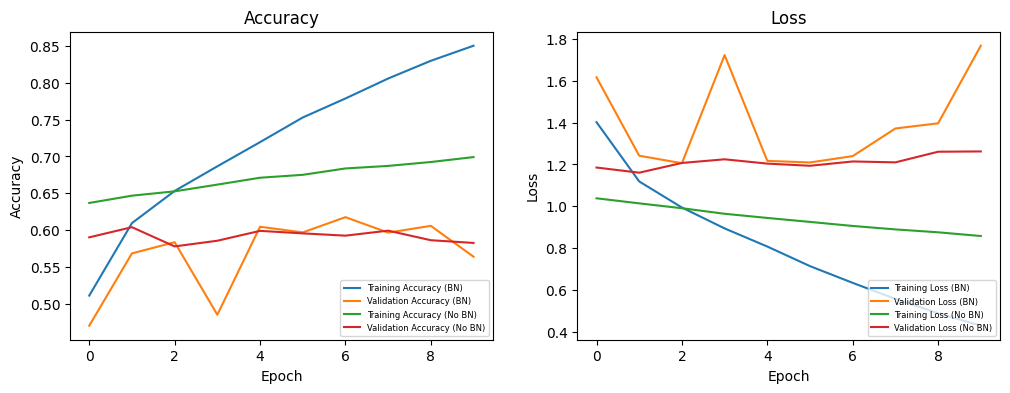

In [ ]:
# BATCH NORMALIZATION

# Define and compile the model with batch normalization
model_bn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='softmax')
])

model_bn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Initialize lists to store metrics
train_accuracy_bn = []
val_accuracy_bn = []
train_loss_bn = []
val_loss_bn = []

# Train the model with batch normalization
history_bn = model_bn.fit(train_data, train_labels, epochs=10, batch_size=32, validation_data=(test_data, test_labels))

# Record metrics
train_accuracy_bn = history_bn.history['accuracy']
val_accuracy_bn = history_bn.history['val_accuracy']
train_loss_bn = history_bn.history['loss']
val_loss_bn = history_bn.history['val_loss']


# Initialize lists to store metrics for null model
train_accuracy_no_bn = []
val_accuracy_no_bn = []
train_loss_no_bn = []
val_loss_no_bn = []

# Train the model without batch normalization
history_no_bn = nullmodel.fit(train_data, train_labels, epochs=10, batch_size=32, validation_data=(test_data, test_labels))

# Record metrics
train_accuracy_no_bn = history_no_bn.history['accuracy']
val_accuracy_no_bn = history_no_bn.history['val_accuracy']
train_loss_no_bn = history_no_bn.history['loss']
val_loss_no_bn = history_no_bn.history['val_loss']

# Visualize the results
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy_bn, label='Training Accuracy (BN)')
plt.plot(val_accuracy_bn, label='Validation Accuracy (BN)')
plt.plot(train_accuracy_no_bn, label='Training Accuracy (No BN)')
plt.plot(val_accuracy_no_bn, label='Validation Accuracy (No BN)')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right', fontsize=6)

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss_bn, label='Training Loss (BN)')
plt.plot(val_loss_bn, label='Validation Loss (BN)')
plt.plot(train_loss_no_bn, label='Training Loss (No BN)')
plt.plot(val_loss_no_bn, label='Validation Loss (No BN)')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right', fontsize=6)

plt.savefig('batchnormalization.jpeg')

plt.show()


### Complex model vs Simplified model

In [ ]:
# FORCE AND SOLVE OVERFITTING
# Define complex model
complex_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(10, activation='softmax')
])


complex_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the complex model (added epochs)
history_complex = complex_model.fit(train_data, train_labels, epochs=50, validation_data=(test_data, test_labels), verbose=1)

Epoch 1/50
1563/1563 [==============================] - 19s 8ms/step - loss: 1.3780 - accuracy: 0.5003 - val_loss: 1.0335 - val_accuracy: 0.6343
Epoch 2/50
1563/1563 [==============================] - 11s 7ms/step - loss: 0.8807 - accuracy: 0.6906 - val_loss: 0.8298 - val_accuracy: 0.7145
Epoch 3/50
1563/1563 [==============================] - 10s 6ms/step - loss: 0.6861 - accuracy: 0.7614 - val_loss: 0.7306 - val_accuracy: 0.7449
Epoch 4/50
1563/1563 [==============================] - 10s 7ms/step - loss: 0.5610 - accuracy: 0.8027 - val_loss: 0.7638 - val_accuracy: 0.7436
Epoch 5/50
1563/1563 [==============================] - 10s 7ms/step - loss: 0.4679 - accuracy: 0.8373 - val_loss: 0.7296 - val_accuracy: 0.7679
Epoch 6/50
1563/1563 [==============================] - 11s 7ms/step - loss: 0.3835 - accuracy: 0.8646 - val_loss: 0.7737 - val_accuracy: 0.7610
Epoch 7/50
1563/1563 [==============================] - 10s 7ms/step - loss: 0.3252 - accuracy: 0.8845 - val_loss: 0.8366 - val_ac

In [ ]:
with open('/content/drive/MyDrive/AML_Project/cifar/complexModel.pkl', 'wb') as f:
    pickle.dump(history_complex.history, f)

In [ ]:
simplified_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

simplified_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history_simplified = simplified_model.fit(train_data, train_labels, epochs=50, validation_data=(test_data, test_labels), verbose=1)


Epoch 1/50
1563/1563 [==============================] - 23s 11ms/step - loss: 1.5736 - accuracy: 0.4556 - val_loss: 1.1179 - val_accuracy: 0.6090
Epoch 2/50
1563/1563 [==============================] - 17s 11ms/step - loss: 1.0537 - accuracy: 0.6306 - val_loss: 0.8617 - val_accuracy: 0.6945
Epoch 3/50
1563/1563 [==============================] - 18s 12ms/step - loss: 0.8697 - accuracy: 0.6981 - val_loss: 0.7722 - val_accuracy: 0.7300
Epoch 4/50
1563/1563 [==============================] - 20s 13ms/step - loss: 0.7740 - accuracy: 0.7325 - val_loss: 0.6835 - val_accuracy: 0.7619
Epoch 5/50
1563/1563 [==============================] - 18s 12ms/step - loss: 0.6898 - accuracy: 0.7646 - val_loss: 0.5944 - val_accuracy: 0.7953
Epoch 6/50
1563/1563 [==============================] - 17s 11ms/step - loss: 0.6304 - accuracy: 0.7852 - val_loss: 0.6645 - val_accuracy: 0.7680
Epoch 7/50
1563/1563 [==============================] - 16s 10ms/step - loss: 0.5881 - accuracy: 0.8016 - val_loss: 0.5710 -

In [ ]:
history_simplified = None
with open('/content/drive/MyDrive/AML_Project/cifar/simplifiedModel.pkl', 'rb') as f:
    history_simplified = pickle.load(f)

In [ ]:
history_simplified

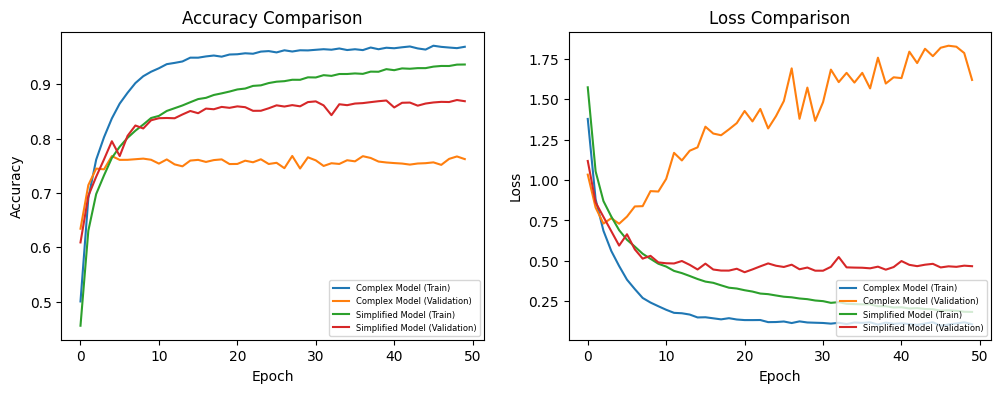

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_complex.history['accuracy'], label='Complex Model (Train)')
plt.plot(history_complex.history['val_accuracy'], label='Complex Model (Validation)')
plt.plot(history_simplified.history['accuracy'], label='Simplified Model (Train)')
plt.plot(history_simplified.history['val_accuracy'], label='Simplified Model (Validation)')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right', fontsize=6)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_complex.history['loss'], label='Complex Model (Train)')
plt.plot(history_complex.history['val_loss'], label='Complex Model (Validation)')
plt.plot(history_simplified.history['loss'], label='Simplified Model (Train)')
plt.plot(history_simplified.history['val_loss'], label='Simplified Model (Validation)')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right', fontsize=6)

plt.savefig('complexsimple.jpeg')

plt.show()

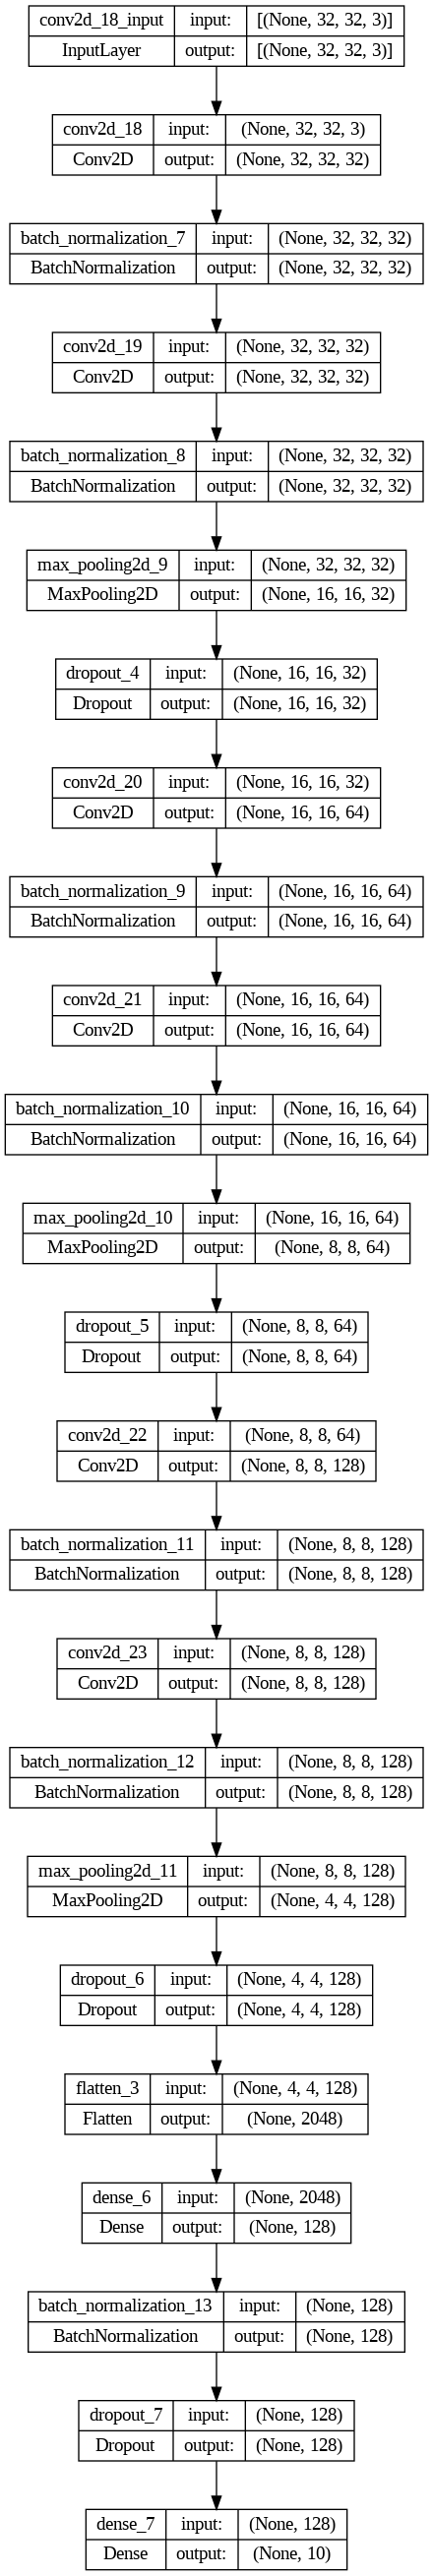

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(simplified_model, show_shapes=True, show_layer_names=True)

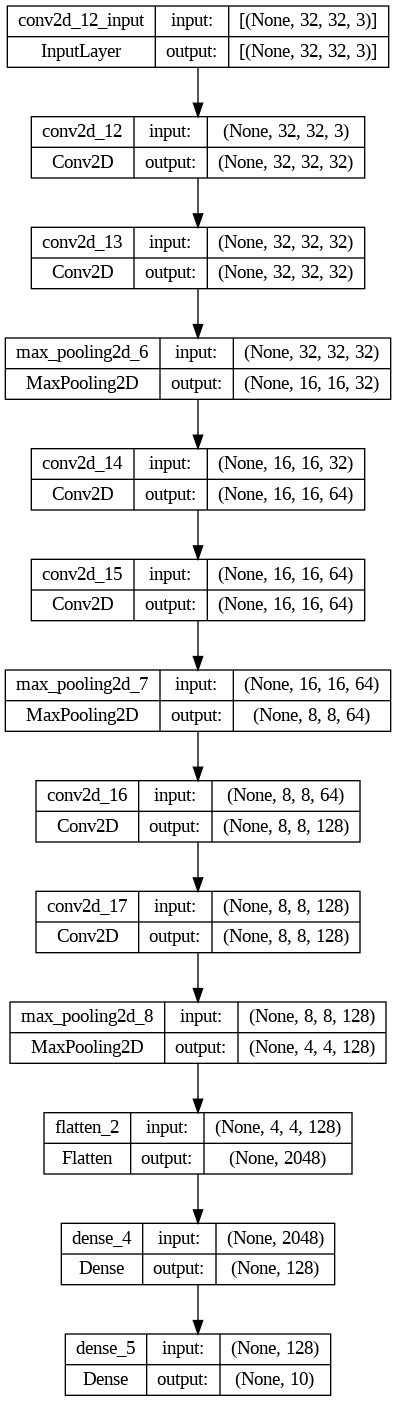

In [ ]:
plot_model(complex_model, show_shapes=True, show_layer_names=True)

In [ ]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 11.0 MB/s eta 0:00:00


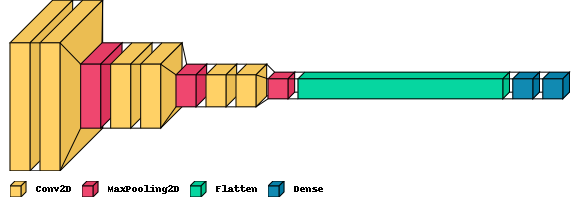

In [ ]:
from PIL import ImageFont
visualkeras.layered_view(complex_model, legend=True)

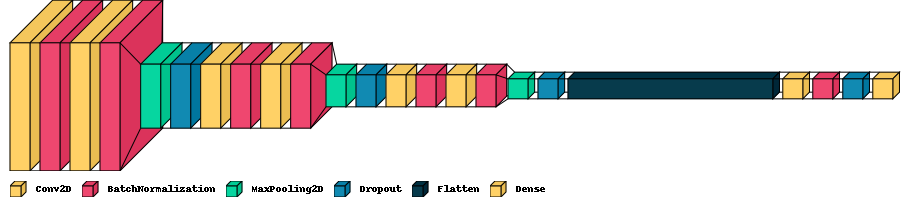

In [ ]:
visualkeras.layered_view(simplified_model, legend=True)